<h1 align="center">CSI1006 - MINIPROJECT

<h1 align="center">Title - ID Card Detection Using Computer Vision</h1>

<h1 align="center">Team Members

<h3 align="center">Priyanshi Premkumar - 19MIC0051</h3>
<h3 align="center">Ravuri Yashaswini Tejaswi - 19MIC0052</h3>
<h3 align="center">Aravinth R - 19MIC0053</h3>

# 1. Setup and Get Data
# 1.1 Install Dependencies and Setup

# 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 1.3 Annotate Images with LabelMe

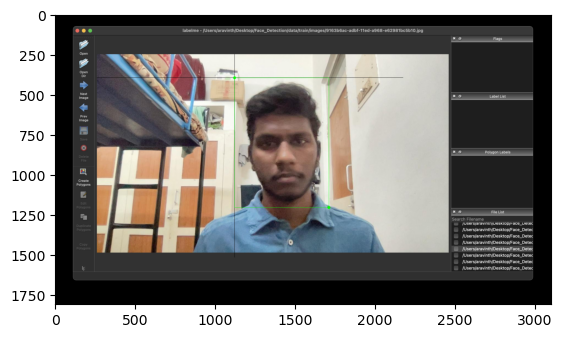

In [209]:
annotate_img=cv2.imread('/Users/aravinth/Desktop/Miniproject/Images/LABEL.png')
img_rgb = cv2.cvtColor(annotate_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# 2. Review Dataset and Build Image Loading Function
# 2.1 Import TF and Deps

In [11]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

/Users/aravinth/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/aravinth/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/aravinth/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/aravinth/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/aravinth/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlopen(/Users/a

# 2.2 Limit GPU Memory Growth

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2.3 Load Image into TF Data Pipeline

In [18]:
images = tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)

In [19]:
images.as_numpy_iterator().next()

b'data/images/46382208-adbf-11ed-a968-e62981bc5b10.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [21]:
images = images.map(load_image)

In [22]:
images.as_numpy_iterator().next()

2023-02-16 12:43:17.663558: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[ 1,  1,  1],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 8, 12, 13],
        [ 9, 13, 14],
        [ 7, 11, 12]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [11, 15, 16],
        [11, 15, 16],
        [ 5,  9, 10]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1],
        ...,
        [14, 18, 19],
        [ 7, 11, 12],
        [ 1,  5,  6]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  0],
        ...,
        [ 5,  9, 10],
        [ 9, 10, 12],
        [ 4,  5,  7]],

       [[ 1,  1,  0],
        [ 2,  2,  0],
        [ 1,  1,  0],
        ...,
        [ 0,  3,  4],
        [ 4,  5,  7],
        [ 6,  7,  9]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  0],
        ...,
        [ 5,  9, 10],
        [ 7,  8, 10],
        [ 0,  0,  2]]], dtype=uint8)

In [23]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 2.4 View Raw Images with Matplotlib

In [24]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

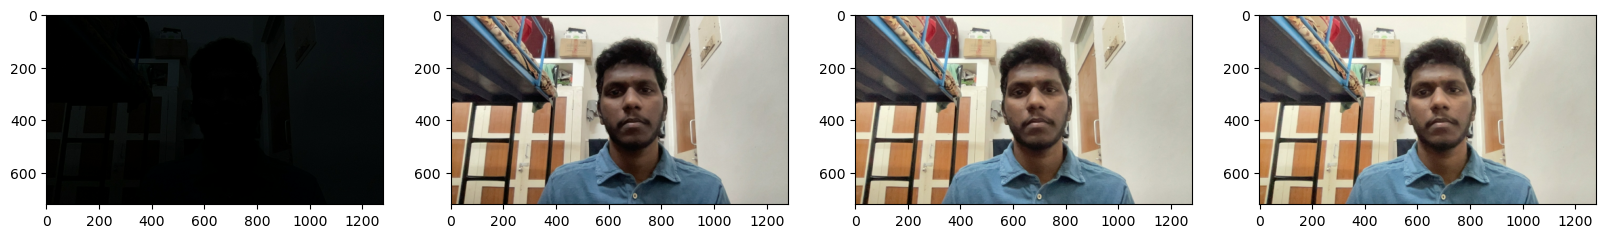

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data
# 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL
# 3.2 Move the Matching Labels

In [27]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations
# 4.1 Setup Albumentations Transform Pipeline

In [28]:
import albumentations as alb

In [53]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [83]:
img=cv2.imread(os.path.join('data', 'train', 'images','4c4bc4c4-adbf-11ed-a968-e62981bc5b10.jpg'))

In [84]:
img.shape

(720, 1280, 3)

# 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [85]:
with open(os.path.join('data', 'train', 'labels', '4c4bc4c4-adbf-11ed-a968-e62981bc5b10.json'), 'r') as f:
    label = json.load(f)

In [86]:
label['shapes'][0]['points']

[[489.4186046511628, 120.46511627906979],
 [803.3720930232557, 537.9069767441861]]

# 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [87]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [88]:
coords

[489.4186046511628, 120.46511627906979, 803.3720930232557, 537.9069767441861]

In [89]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [90]:
coords

[0.3823582848837209,
 0.16731266149870805,
 0.6276344476744186,
 0.747093023255814]

# 4.4 Apply Augmentations and View Results

In [91]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [93]:
augmented['bboxes'][0][2:]

(1.0, 0.9175710594315246)

In [92]:
augmented['bboxes']

[(0.44361757105943167, 0.0, 1.0, 0.9175710594315246)]

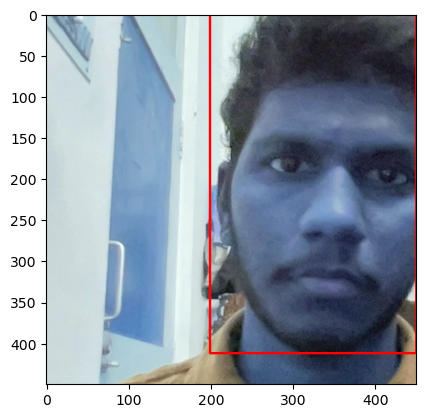

In [94]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline
# 5.1 Run Augmentation Pipeline

In [95]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6539789244186046, 0.6921834625322998, 0.4504905523255814, 0.17377260981912152, 'face'].
x_max is less than or equal to x_min for bbox [0.5731286337209303, 0.7196382428940568, 0.36782340116279066, 0.17538759689922487, 'face'].
x_max is less than or equal to x_min for bbox [0.7302870639534883, 0.7406330749354006, 0.494095203488372, 0.1608527131782946, 'face'].
x_max is less than or equal to x_min for bbox [0.6939498546511628, 0.7180232558139535, 0.45775799418604646, 0.13501291989664085, 'face'].
image must be numpy array type
x_max is less than or equal to x_min for bbox [0.6021984011627907, 0.6954134366925065, 0.36328125, 0.15600775193798452, 'face'].
x_max is less than or equal to x_min for bbox [0.7302870639534883, 0.6711886304909561, 0.440627718817323, -7.894919286223336e-17, 'face'].
x_max is less than or equal to x_min for bbox [0.6112827034883721, 0.7503229974160207, 0.3551053779069767, 0.14470284237726103, 'face'].
x_max is less th

# 5.2 Load Augmented Images to Tensorflow Dataset

In [97]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [99]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [100]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [101]:
train_images.as_numpy_iterator().next()

array([[[0.9499387 , 0.94601715, 0.8754289 ],
        [0.9490196 , 0.94509804, 0.8745098 ],
        [0.9465686 , 0.94264704, 0.8720588 ],
        ...,
        [0.2028799 , 0.16758579, 0.18719363],
        [0.21783088, 0.17469363, 0.20079657],
        [0.2189951 , 0.17585784, 0.20723039]],

       [[0.9566789 , 0.9449142 , 0.8860907 ],
        [0.9529412 , 0.9411765 , 0.88235295],
        [0.95251226, 0.94074756, 0.88192403],
        ...,
        [0.21366422, 0.17444853, 0.20582108],
        [0.22285539, 0.17971814, 0.21109068],
        [0.2096201 , 0.16648284, 0.1978554 ]],

       [[0.9490196 , 0.9411765 , 0.88235295],
        [0.9460784 , 0.9382353 , 0.87941176],
        [0.94558823, 0.94166666, 0.87107843],
        ...,
        [0.2608456 , 0.2216299 , 0.25692403],
        [0.24430147, 0.20067401, 0.23302697],
        [0.23314951, 0.19246323, 0.22383578]],

       ...,

       [[0.89656866, 0.87990195, 0.7607843 ],
        [0.8867647 , 0.875     , 0.7534314 ],
        [0.88670343, 0

# 6. Prepare Labels
# 6.1 Build Label Loading Function

In [102]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

# 6.2 Load Labels to Tensorflow Dataset

In [103]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [104]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [105]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [106]:
 train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples
# 7.1 Check Partition Lengths

In [107]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1440, 1440, 420, 420, 300, 300)

# 7.2 Create Final Datasets (Images/Labels)

In [108]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [109]:
 test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [110]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [113]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4004  , 0.4216  , 1.      , 1.      ],
        [0.      , 0.1998  , 0.533   , 1.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.171   , 0.651   , 1.      ],
        [0.      , 0.      , 0.548   , 0.843   ],
        [0.010284, 0.2468  , 0.708   , 1.      ],
        [0.5166  , 0.2186  , 1.      , 1.      ],
        [0.      , 0.      , 0.05978 , 0.87    ]], dtype=float16))

# 7.3 View Images and Annotations

In [114]:
data_samples = train.as_numpy_iterator()

In [121]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


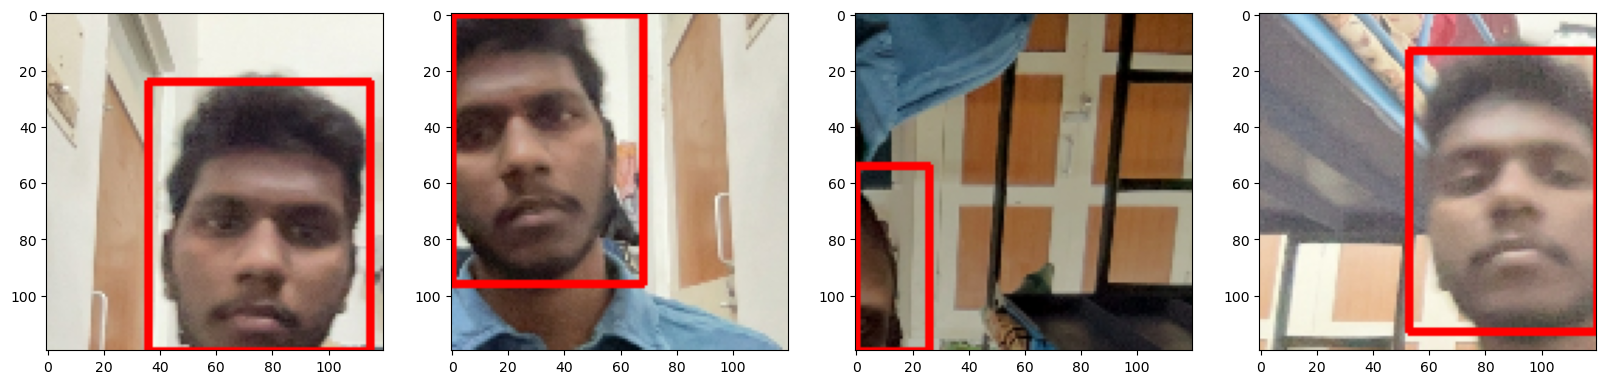

In [122]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API
# 8.1 Import Layers and Base Network

In [123]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# 8.2 Download VGG16

In [124]:
 vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 100s 2us/step


In [125]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 8.3 Build instance of Network

In [126]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

# 8.4 Test out Neural Network

In [127]:
facetracker = build_model()

In [128]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [129]:
X, y = train.as_numpy_iterator().next()

In [130]:
X.shape

(8, 120, 120, 3)

In [131]:
classes, coords = facetracker.predict(X)

2023-02-16 13:28:37.633646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 808ms/step


In [132]:
classes, coords

(array([[0.6259747 ],
        [0.59382623],
        [0.49741545],
        [0.47747394],
        [0.55248594],
        [0.56276584],
        [0.63585925],
        [0.49242952]], dtype=float32),
 array([[0.5983754 , 0.6309455 , 0.49099278, 0.6739345 ],
        [0.48467913, 0.58828115, 0.5424101 , 0.55468875],
        [0.5170546 , 0.4871861 , 0.5205114 , 0.6185404 ],
        [0.598164  , 0.4644391 , 0.5129091 , 0.61688733],
        [0.5216711 , 0.5651785 , 0.48241255, 0.6685559 ],
        [0.45510668, 0.58939517, 0.46975172, 0.6357611 ],
        [0.50966716, 0.6839819 , 0.52431196, 0.6286244 ],
        [0.52737874, 0.5665179 , 0.53119045, 0.5806533 ]], dtype=float32))

# 9. Define Losses and Optimizers
# 9.1 Define Optimizer and LR

In [133]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [134]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

# 9.2 Create Localization Loss and Classification Loss

In [135]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [136]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# 9.3 Test out Loss Metrics

In [137]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.550733>

In [138]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.583303>

In [139]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.550733>

# 10. Train Neural Network
# 10.1 Create Custom Model Class

In [140]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [141]:
model = FaceTracker(facetracker)

In [142]:
model.compile(opt, classloss, regressloss)

# 10.2 Train

In [143]:
logdir='logs'

In [144]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [145]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2023-02-16 13:33:17.789723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - ETA: 0s - total_loss: 1.3217 - class_loss: 0.2562 - regress_loss: 1.1936

2023-02-16 13:33:52.215419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 37s 183ms/step - total_loss: 1.3184 - class_loss: 0.2561 - regress_loss: 1.1904 - val_total_loss: 0.0696 - val_class_loss: 0.0054 - val_regress_loss: 0.0669
Epoch 2/10
180/180 [==============================] - 34s 182ms/step - total_loss: 0.5898 - class_loss: 0.1323 - regress_loss: 0.5236 - val_total_loss: 1.7244 - val_class_loss: 1.1199 - val_regress_loss: 1.1644
Epoch 3/10
180/180 [==============================] - 35s 185ms/step - total_loss: 0.4773 - class_loss: 0.1142 - regress_loss: 0.4202 - val_total_loss: 0.0120 - val_class_loss: 1.0085e-04 - val_regress_loss: 0.0119
Epoch 4/10
180/180 [==============================] - 35s 185ms/step - total_loss: 0.4219 - class_loss: 0.1049 - regress_loss: 0.3694 - val_total_loss: 0.0855 - val_class_loss: 0.0398 - val_regress_loss: 0.0656
Epoch 5/10
180/180 [==============================] - 35s 188ms/step - total_loss: 0.3410 - class_loss: 0.0880 - regress_loss: 0.2970 - val_total_loss: 0.0550 - va

# 10.3 Plot Performance

In [146]:
hist.history

{'total_loss': [0.727581262588501,
  0.4161016047000885,
  0.36629873514175415,
  0.07255513221025467,
  0.09118524938821793,
  0.0626346543431282,
  0.051695551723241806,
  0.030080702155828476,
  0.05130729079246521,
  0.07987364381551743],
 'class_loss': [0.23643462359905243,
  0.06586547940969467,
  0.08759793639183044,
  0.012800139375030994,
  0.03100201115012169,
  0.02322273515164852,
  0.016162583604454994,
  9.202869478031062e-06,
  0.009548354893922806,
  0.004765351302921772],
 'regress_loss': [0.6093639731407166,
  0.38316887617111206,
  0.32249975204467773,
  0.06615506112575531,
  0.07568424195051193,
  0.05102328583598137,
  0.043614260852336884,
  0.030076101422309875,
  0.04653311148285866,
  0.07749097049236298],
 'val_total_loss': [0.06957364827394485,
  1.7243683338165283,
  0.011975809000432491,
  0.08553417772054672,
  0.055033642798662186,
  0.012013362720608711,
  0.0191273782402277,
  0.5296543836593628,
  0.0062990435399115086,
  0.027707742527127266],
 'val_

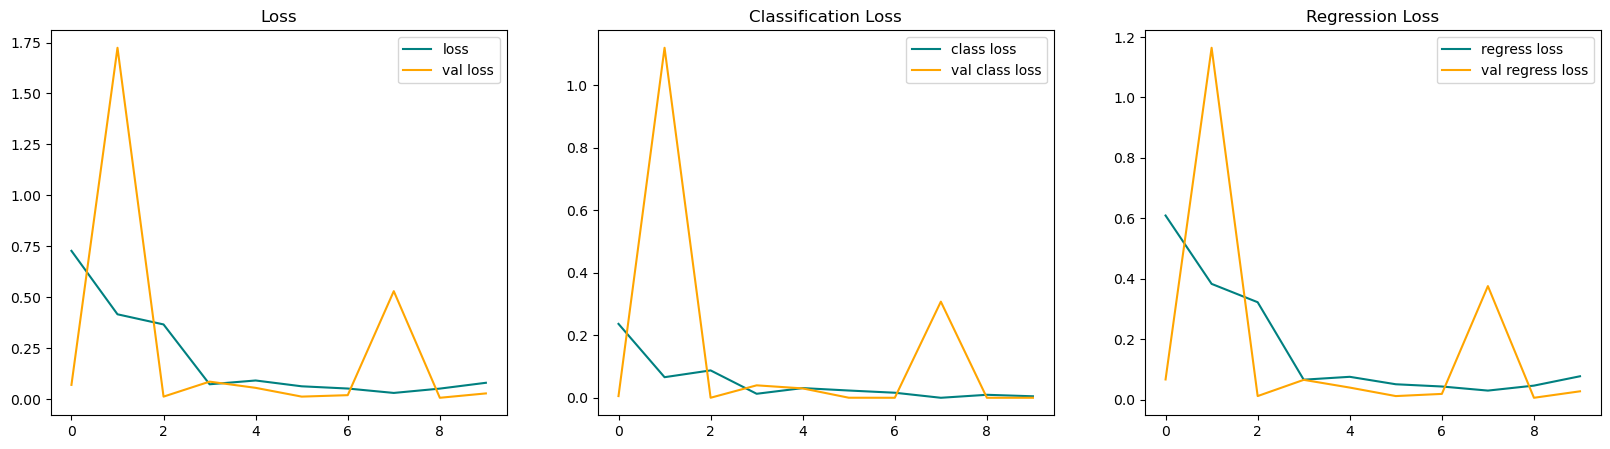

In [147]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions
# 11.1 Make Predictions on Test Set

In [148]:
test_data = test.as_numpy_iterator()

In [164]:
test_sample = test_data.next()

In [165]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


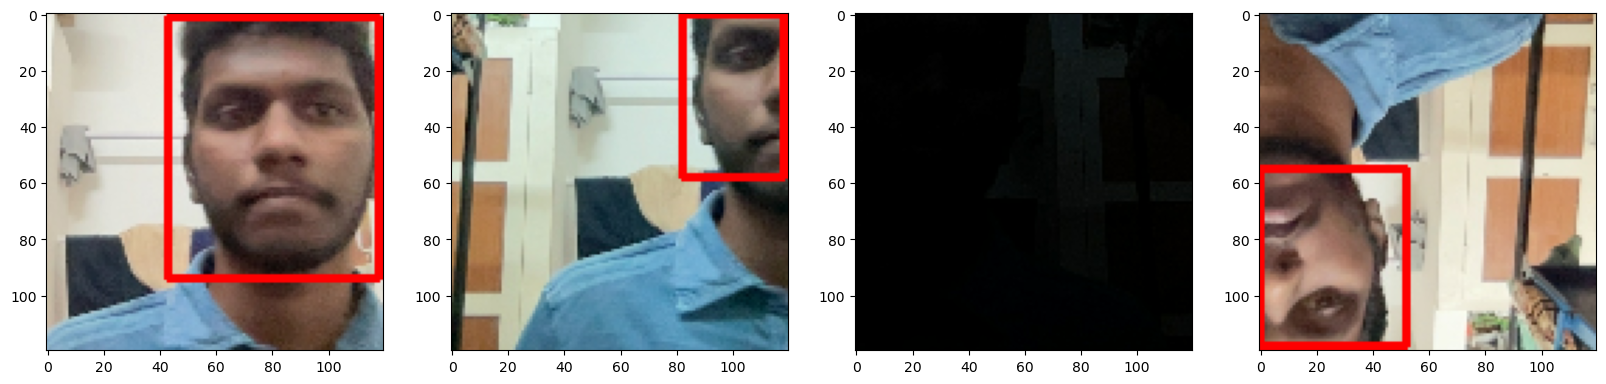

In [166]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# 11.2 Save the Model

In [153]:
from tensorflow.keras.models import load_model

In [154]:
facetracker.save('miniproject.h5')

In [155]:
facetracker = load_model('miniproject.h5')

# 11.3 Real Time Detection

In [198]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[20:500, 20:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Face_Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


# Output

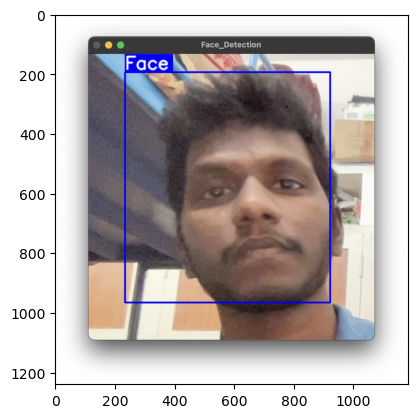

In [207]:
input_img=cv2.imread('/Users/aravinth/Desktop/Miniproject/Images/Output.JPG')
img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
